# Simple convex decomposition

9/17/211

1. CVXPY + MOSEK
2. Hybrid algorithm: SD-BCD --> SD-ADMM
3. SD-BCD
4. SD-ADMM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex
from osd.utilities import progress
from osd.signal_decomp_admm import calc_obj
from osd.signal_decomp_bcd import run_bcd

In [4]:
%matplotlib notebook

## Data generation

In [5]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.25 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

<IPython.core.display.Javascript object>


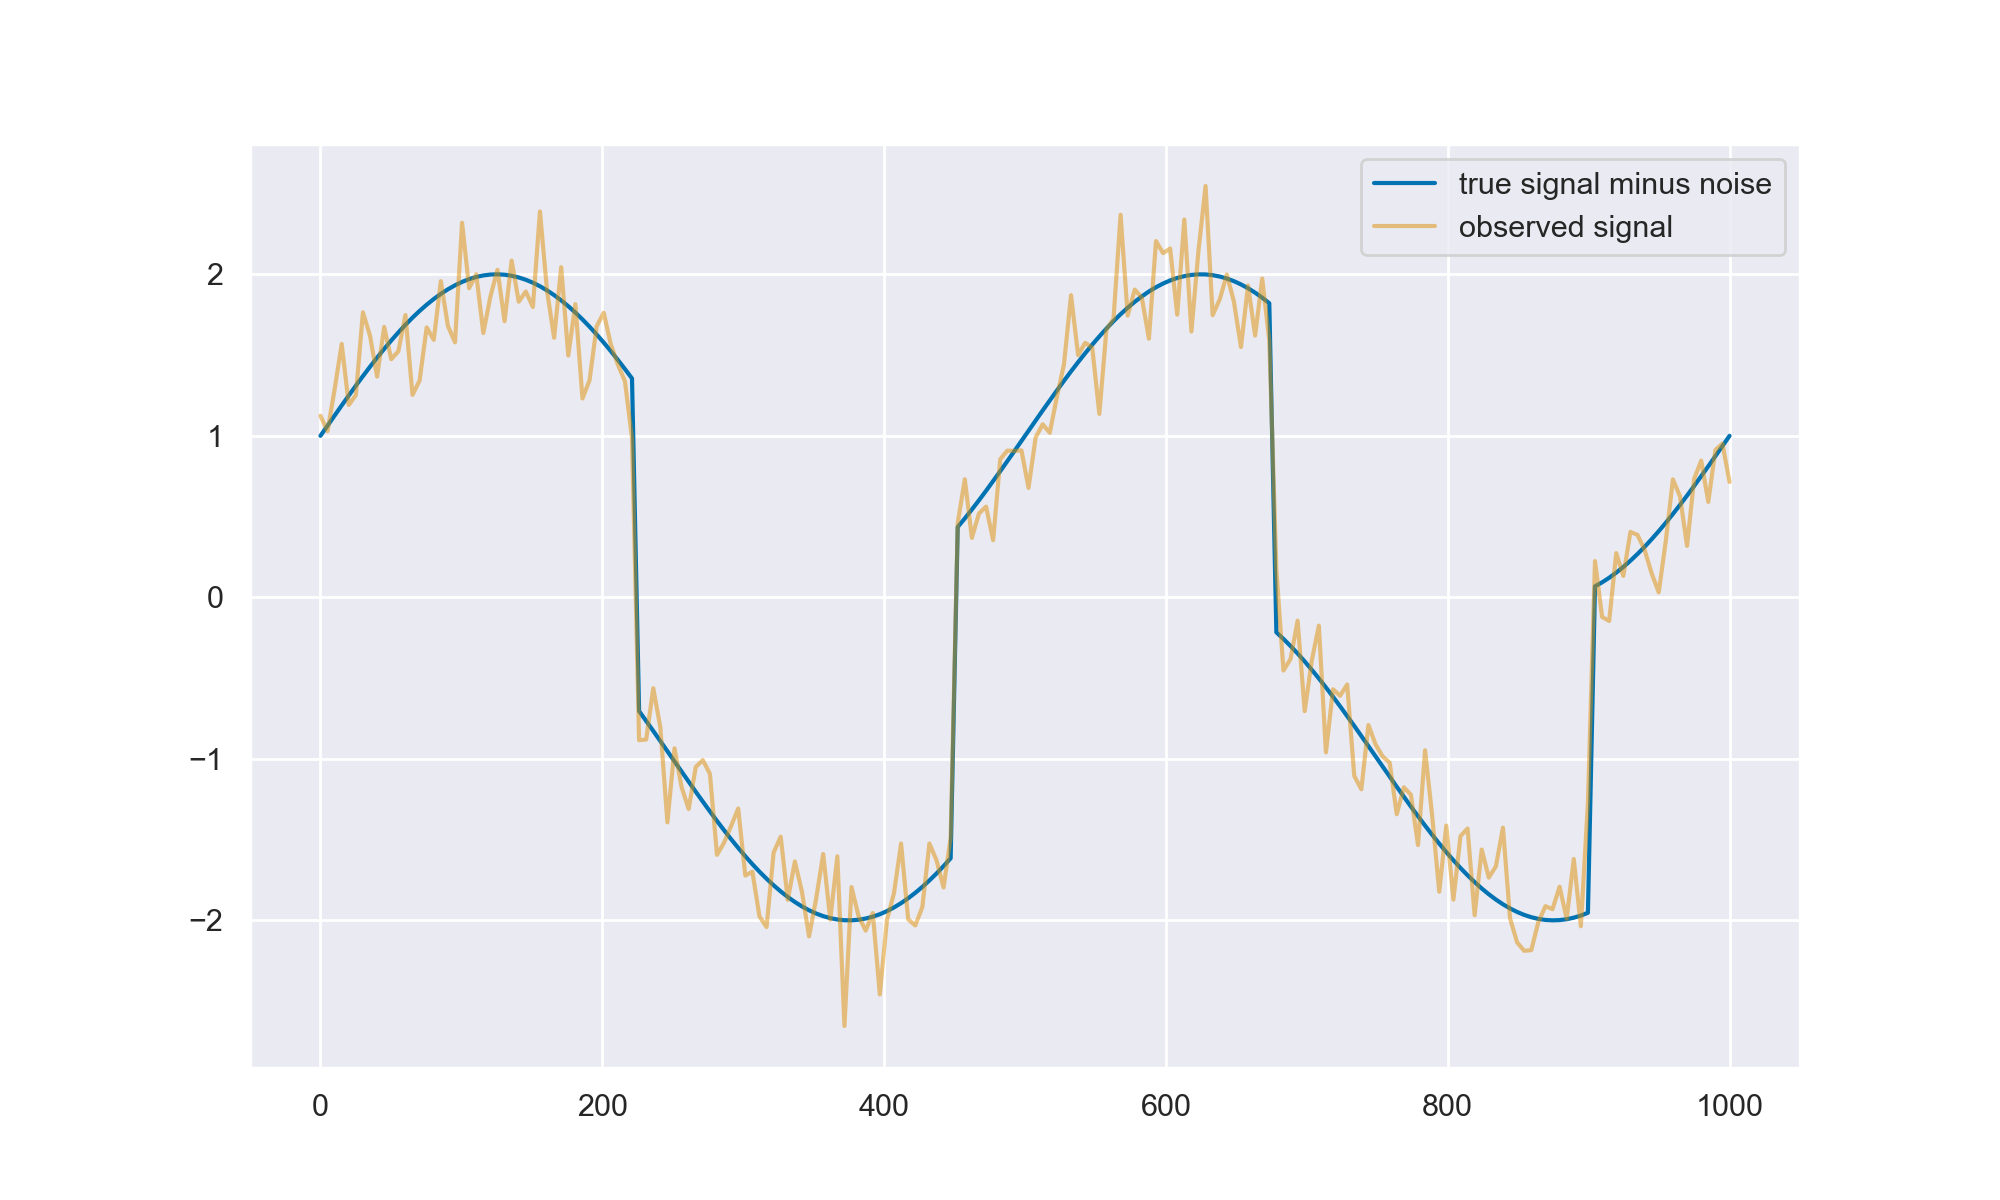

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# CVXPY + MOSEK

In [7]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
components = [c1, c2, c3]
problem1 = Problem(y, components)

In [8]:
problem1.decompose(admm=False)

In [9]:
problem1.objective_value

0.12385538220083664

# SD ADMM

In [34]:
n_iter = 750

In [40]:
switch_after = 20
problem2 = Problem(y, components)
bcd_result2 = run_bcd(problem2.data, problem2.components, num_iter=switch_after)
u_init = (-1) * bcd_result2['X'][0]
# u_init = None
X_init = bcd_result2['X']
problem2.decompose(admm=True, rho=2/T, num_iter=n_iter-switch_after, X_init=X_init, u_init=u_init)
problem2.objective_value

[============================================================] 100.0% ...33.59 sec


0.1238553933487582

In [36]:
problem3 = Problem(y, components)
bcd_result3 = run_bcd(problem3.data, problem3.components, num_iter=n_iter)
problem3.estimates = bcd_result3['X']
problem3.use_set = np.ones_like(y, dtype=bool)
problem3.objective_value

0.12385539368417317

In [37]:
problem4 = Problem(y, components)
problem4.decompose(admm=True, rho=2/T, num_iter=n_iter+1)
problem4.objective_value

[============================================================] 100.0% ...34.75 sec


0.12385539388417034

In [38]:
min_admm = np.zeros_like(problem4.admm_result['obj_vals'])
for it, val in enumerate(problem4.admm_result['obj_vals']):
    if it == 0:
        new_val = val
    else:
        if val <= min_admm[it-1]:
            new_val = val
        else:
            new_val = min_admm[it-1]
    min_admm[it] = new_val

<IPython.core.display.Javascript object>


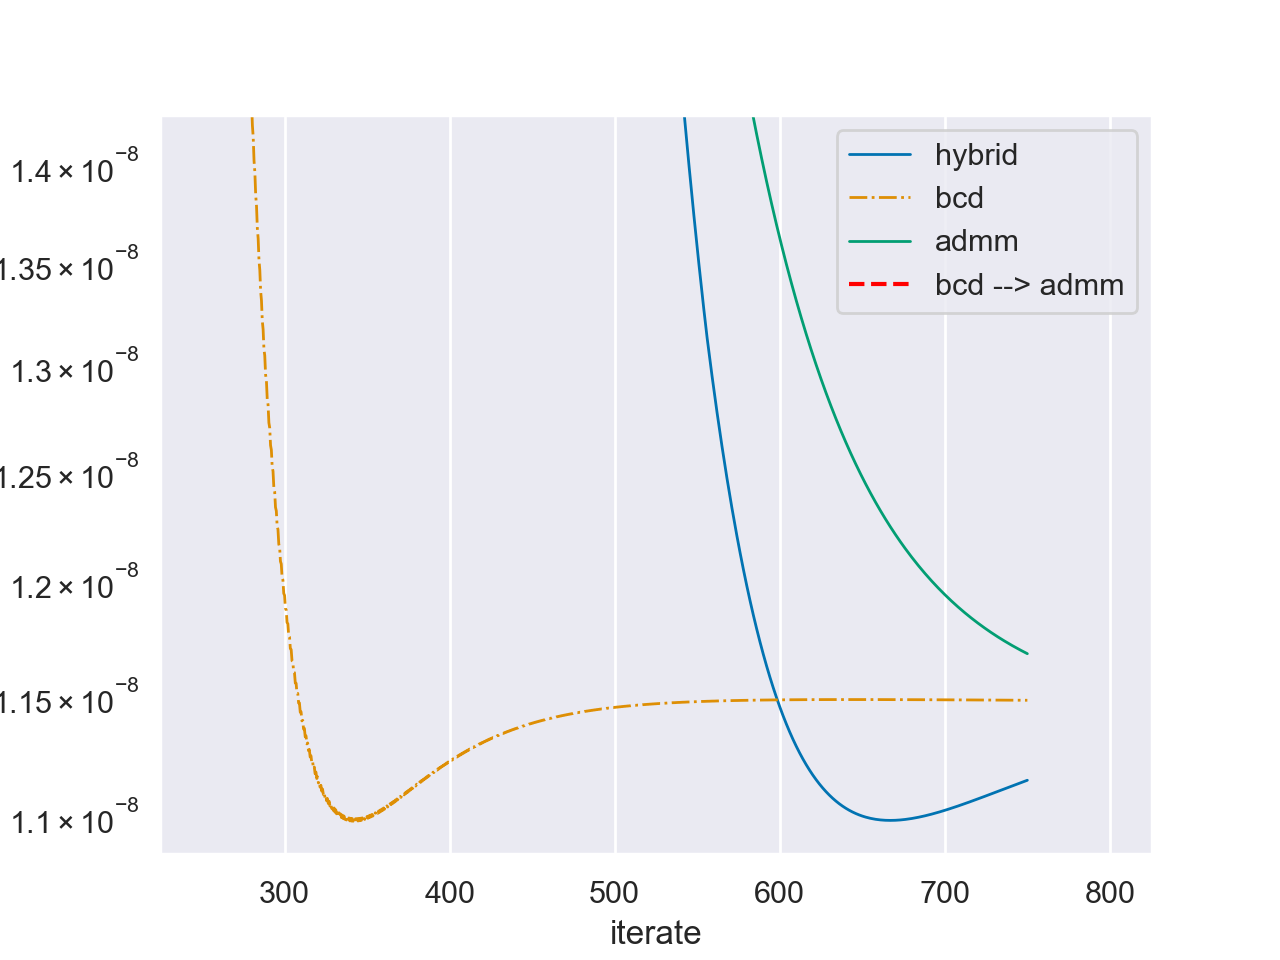

In [41]:
plt.figure()
xs1 = np.arange(len(bcd_result2['obj_vals'])) / 2
xs2 = np.arange(len(problem2.admm_result['obj_vals'])) + xs1[-1] + 1
plt.plot(np.r_[xs1, xs2], 
         np.r_[bcd_result2['obj_vals'], problem2.admm_result['obj_vals']] - problem1.problem.objective.value,
         label='hybrid', linewidth=1)
plt.plot(np.arange(len(bcd_result3['obj_vals']))/ 2, bcd_result3['obj_vals'] - problem1.problem.objective.value, 
         ls='-.', label='bcd', linewidth=1)
# plt.plot(problem4.admm_result['obj_vals'], label='admm')
plt.plot(problem4.admm_result['obj_vals'] - problem1.problem.objective.value, label='admm', linewidth=1)
# plt.plot(min_admm - problem1.problem.objective.value, label='admm min', color='green', linestyle=':', linewidth='1')
# plt.axvline(problem2.admm_result['it'], color='red', ls='--')
# plt.yscale('log')
# plt.ylim(0.11, 0.25)
plt.axvline(xs1[-1], color='red', ls='--', label='bcd --> admm')
# plt.axhline(problem1.problem.objective.value, color='orange', ls='--' , label='MOSEK')
plt.legend()
plt.yscale('log')
plt.ylabel('suboptimality')
plt.xlabel('iterate')
plt.show()

# All the decompositions

<IPython.core.display.Javascript object>


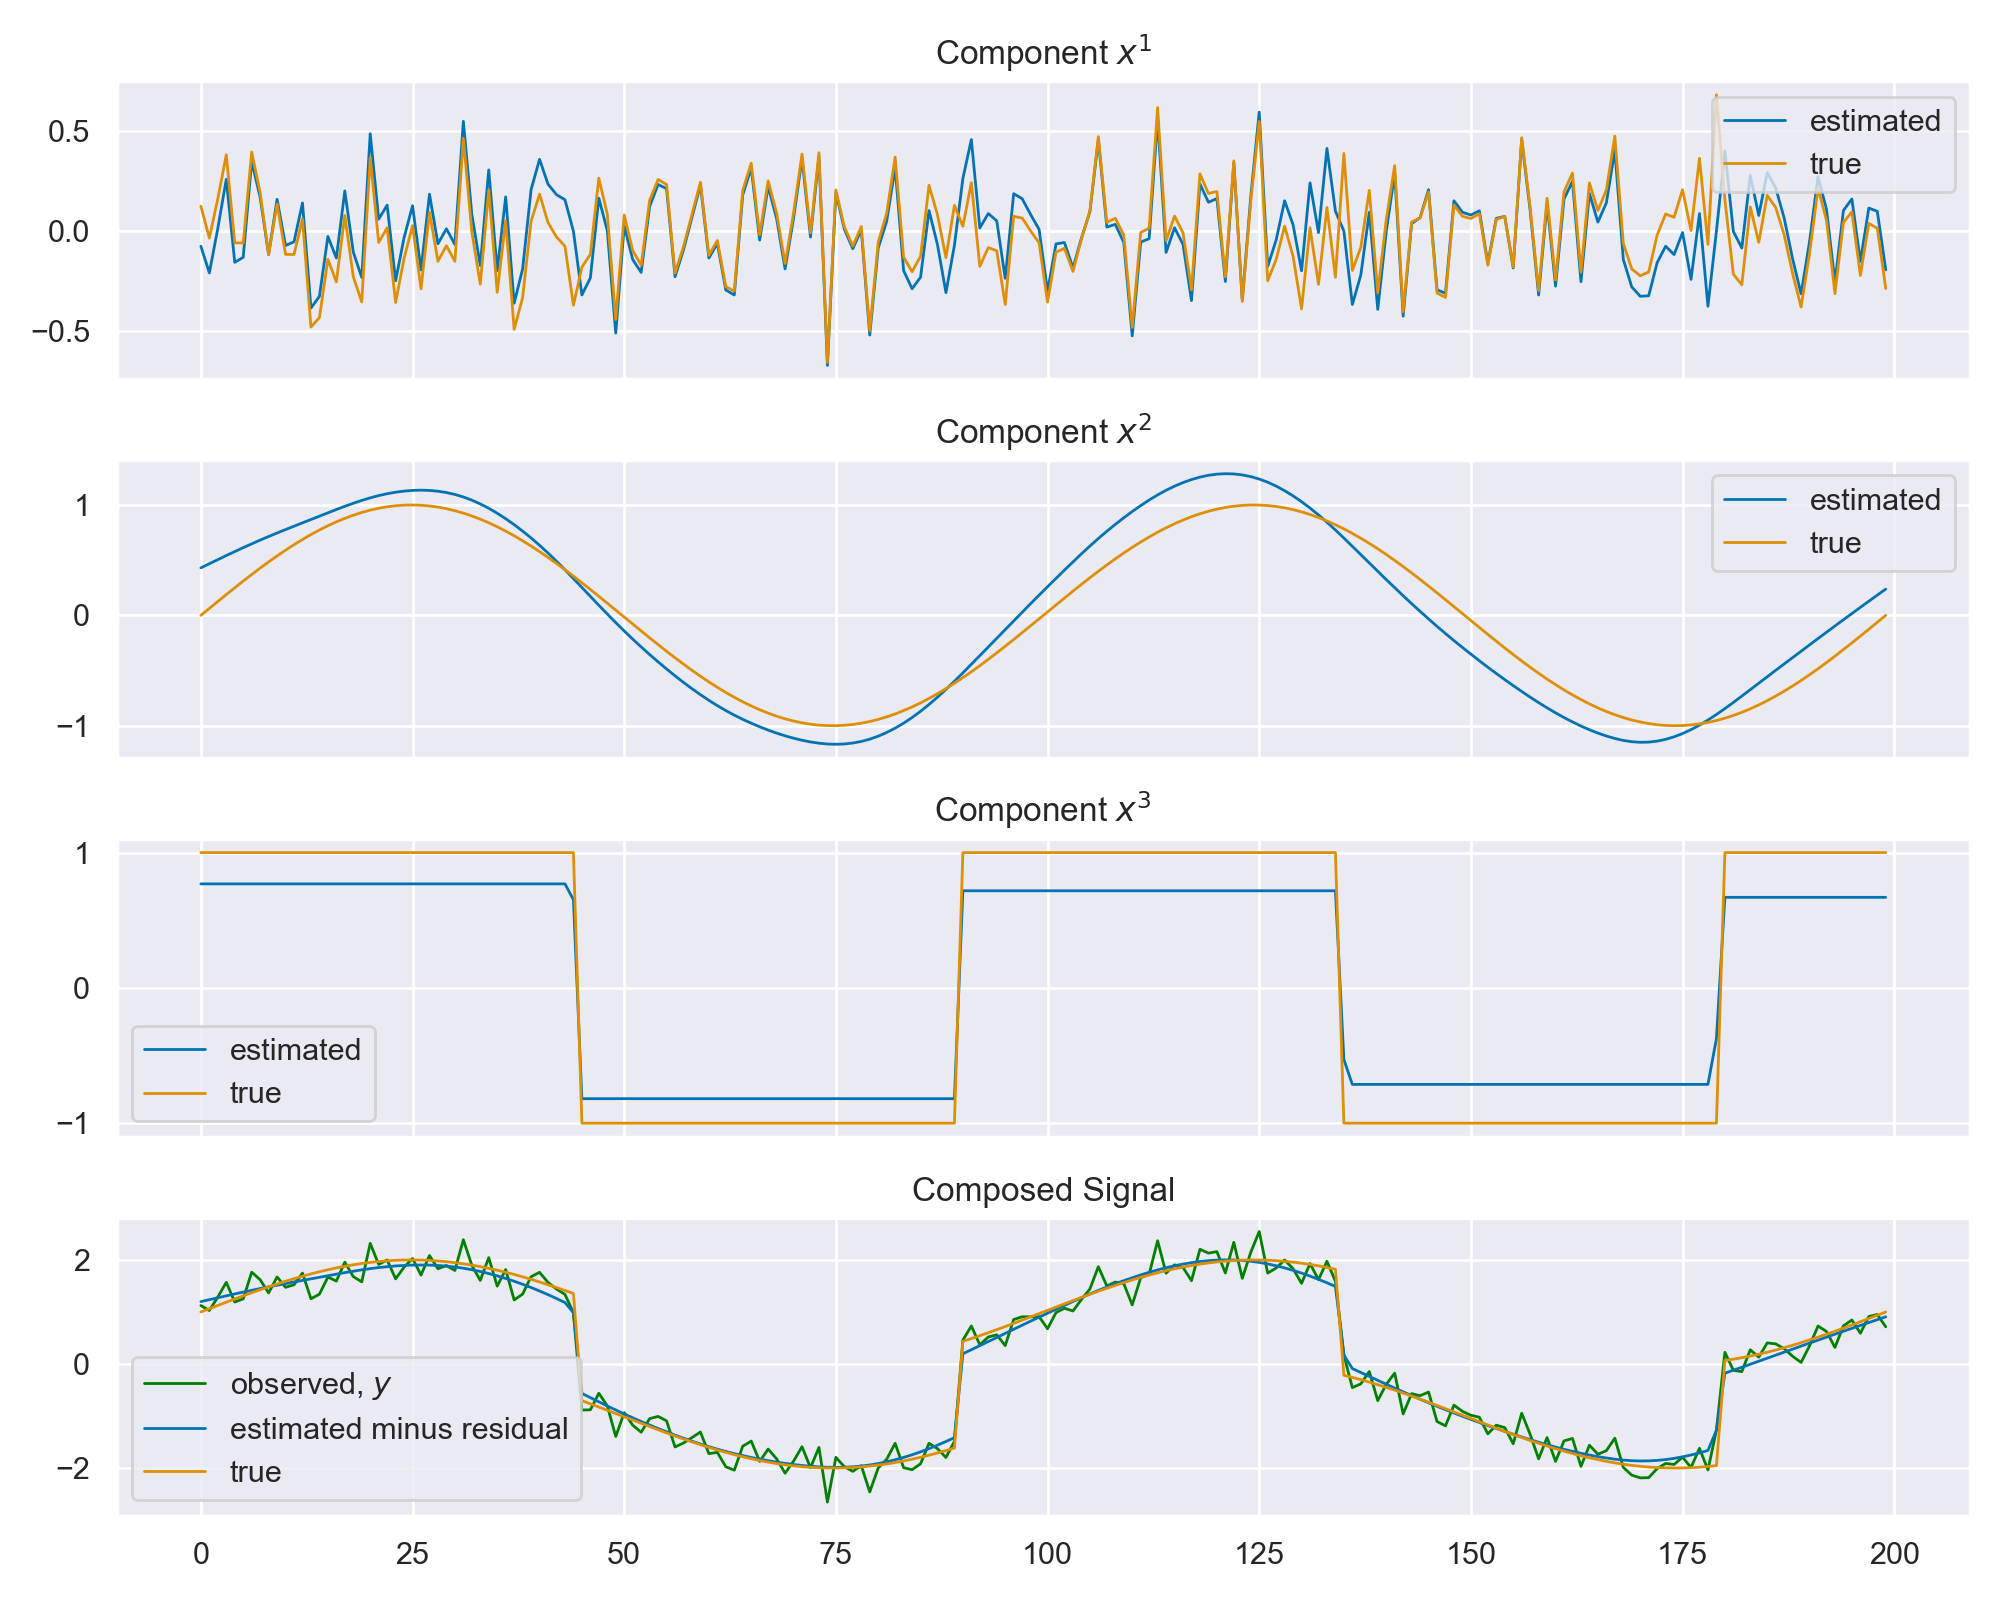

In [21]:
problem1.plot_decomposition(X_real=X_real);

<IPython.core.display.Javascript object>


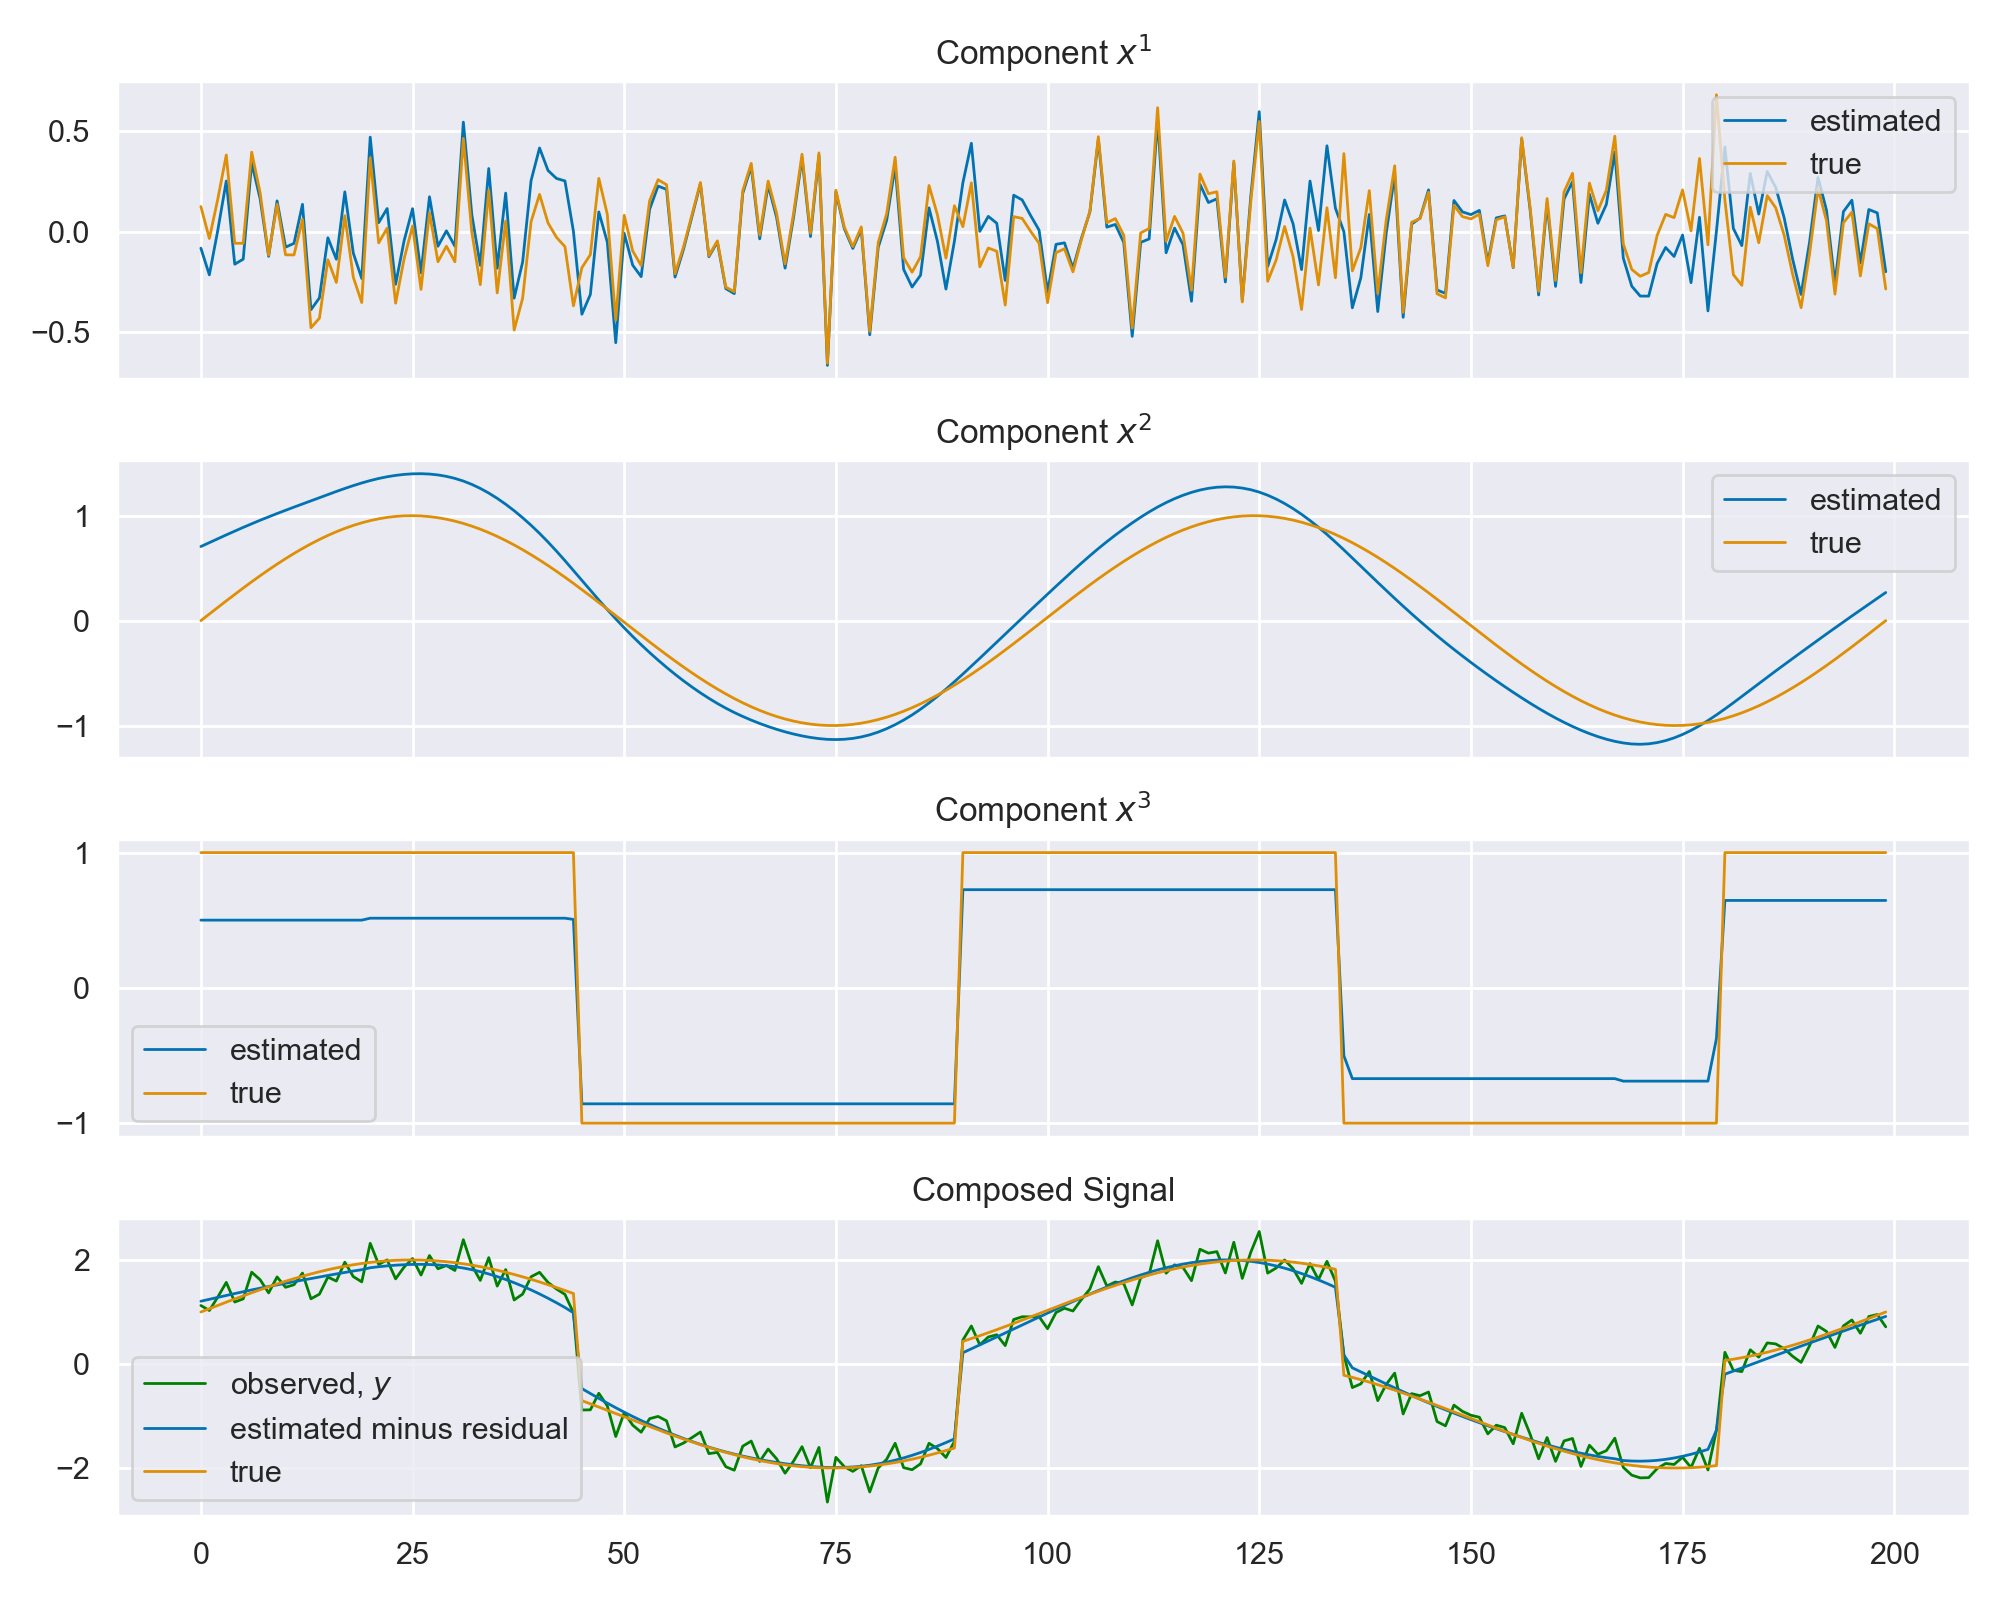

In [22]:
problem2.plot_decomposition(X_real=X_real);

<IPython.core.display.Javascript object>


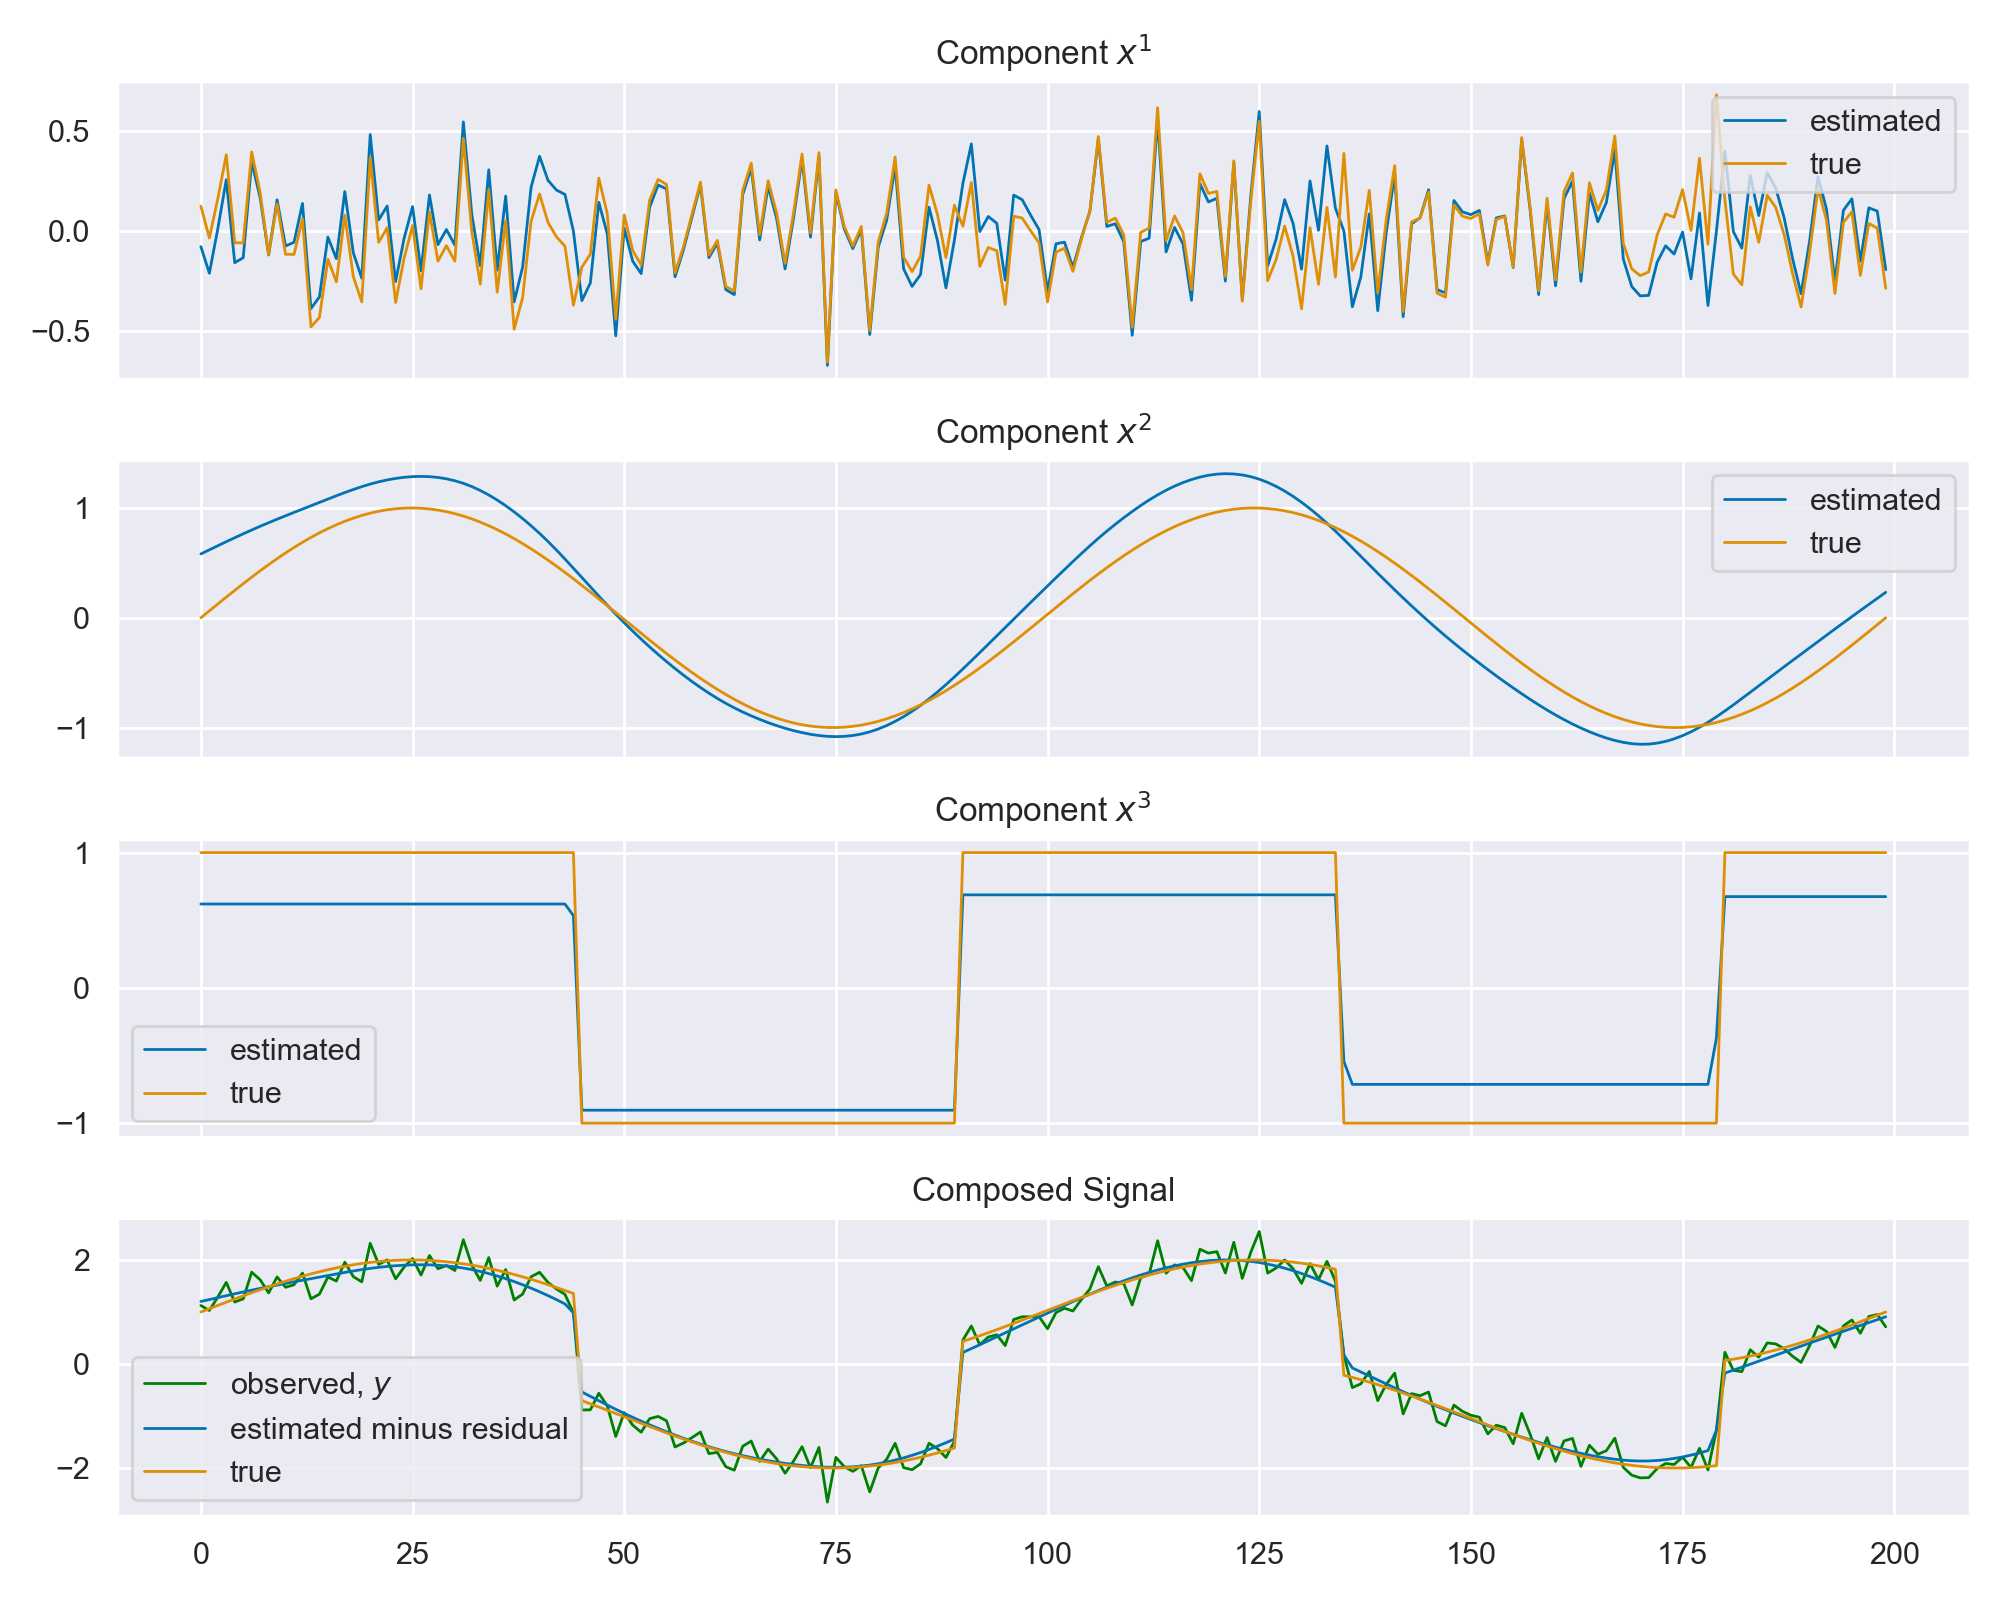

In [23]:
problem3.plot_decomposition(X_real=X_real);

<IPython.core.display.Javascript object>


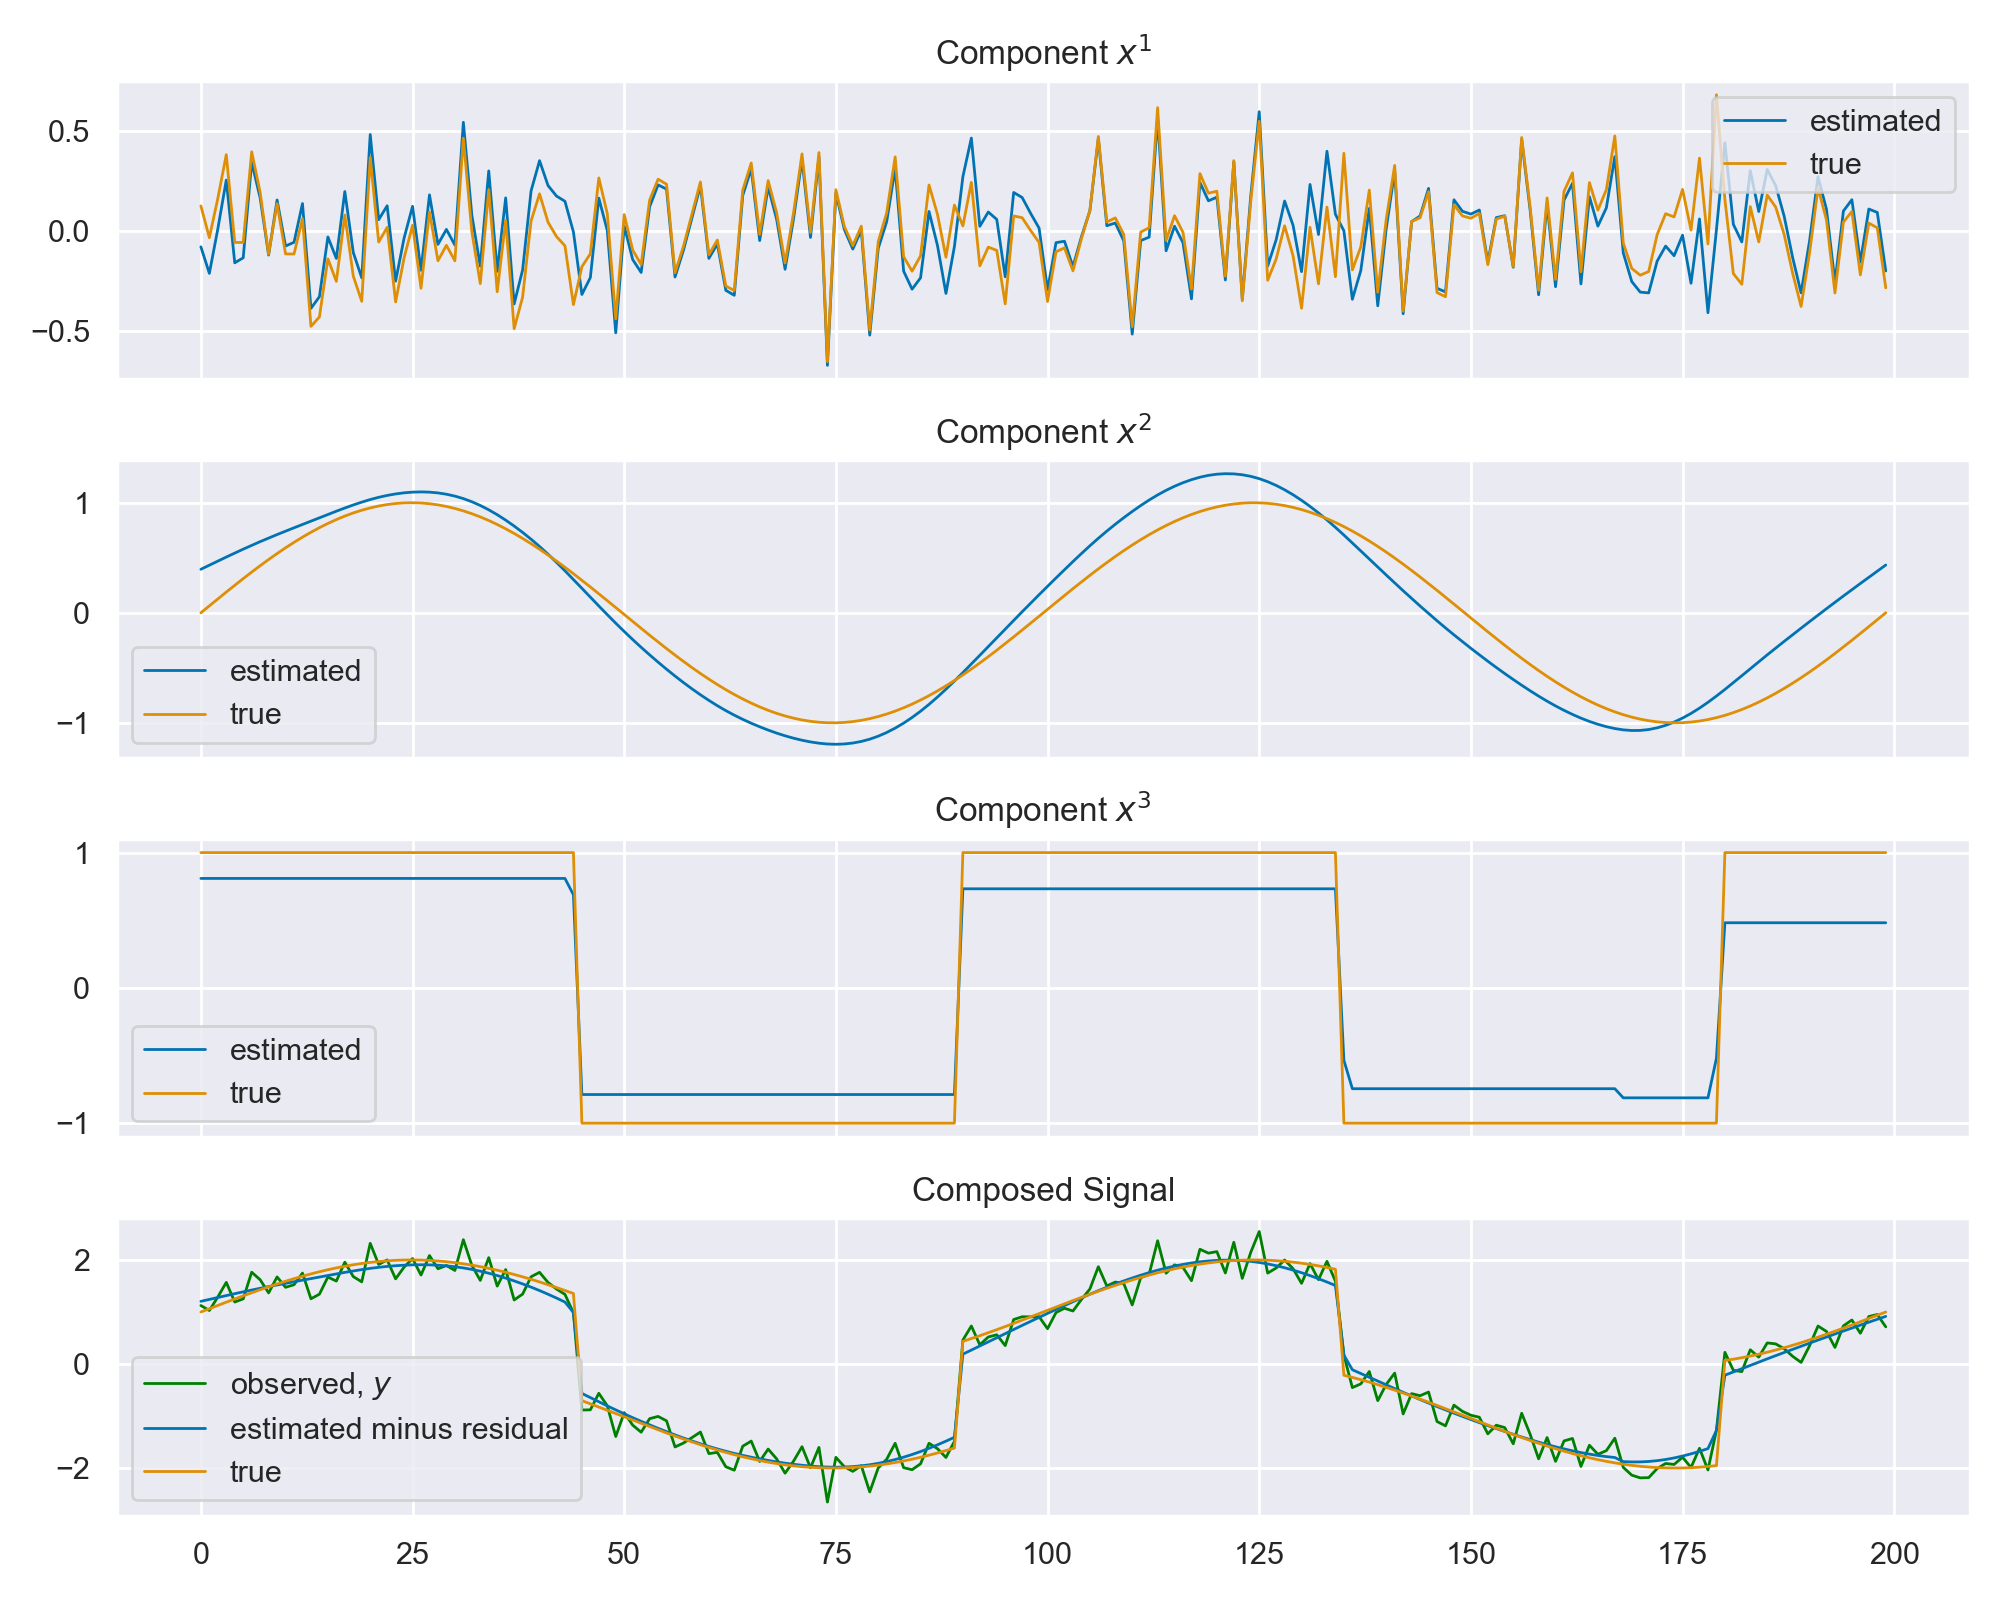

In [24]:
problem4.plot_decomposition(X_real=X_real);